In [1]:
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp
import jax
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Add the parent directory to Python path for proper module resolution
# Get current working directory and navigate to parent (assumes notebook is in examples/ folder)
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

print(f"Current directory: {current_dir}")
print(f"Added to Python path: {parent_dir}")

# Check JAX devices
print(f"\nJAX Configuration:")
print(f"JAX devices available: {jax.devices()}")
print(f"JAX default backend: {jax.default_backend()}")


Current directory: /Scratch/cindy/Skyclean
Added to Python path: /Scratch/cindy

JAX Configuration:
JAX devices available: [CudaDevice(id=0)]
JAX default backend: gpu


In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import s2fft

def mw_alm_2_hp_alm(MW_alm, lmax):
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    return hp_alm

def cl_from_fullsky_map(
    T_map,
    lmax=None,
):
    T_map = np.asarray(T_map, dtype=np.float64)
    nside = hp.get_nside(T_map)
    if lmax is None:
        lmax = 3 * nside - 1
    m = T_map.copy()
    Cl = hp.anafast(m, lmax=lmax)
    # alm = hp.map2alm(m, lmax=lmax) if return_alm else None
    ell = np.arange(lmax + 1)
    return ell, Cl

def Dl_from_Cl(ell, Cl):
    """Convert C_ell to D_ell."""
    Dl = ell * (ell + 1.0) * Cl / (2.0 * np.pi)
    return Dl

def power_spec_from_MW(MW_Pix, Pl=False, Bl=False, save_name='ilc_cmb_1024.npy'):
    lmax = MW_Pix.shape[0] - 1 
    MW_alm = s2fft.forward(MW_Pix, L=lmax+1)
    hp_alm = mw_alm_2_hp_alm(MW_alm, lmax)
    hp_map = hp.alm2map(hp_alm, nside=2048, lmax=lmax, verbose=False) 
    hp.write_map(save_name, hp_map, overwrite=True)
    map_T = hp.read_map(save_name)

    ell, Cl = cl_from_fullsky_map(map_T, lmax=lmax)

    nside = hp.get_nside(map_T)
    lmax_use = min(lmax, 3*nside - 1)
    if Pl:
        Pl = hp.pixwin(nside, lmax=lmax)
    else:
        Pl = 1
    if Bl:
        Bl = hp.gauss_beam(np.deg2rad(5.0/60.0), lmax=lmax_use, pol=False)
    else:
        Bl = 1

    # Deconvolve to get the sky spectrum (guard zeros)
    denom = (Bl**2) * (Pl**2)
    if Pl != 1 and Bl != 1:
        denom[denom == 0] = np.nan
    Cl_sky = Cl / denom

    Dl = Dl_from_Cl(ell, Cl_sky)
    return ell, Dl

def power_spec_from_HP(HP_map, lmax=1023, Pl=False, Bl=False):
    'calculate power spectrum from a Healpix map, deconvolve beam and pixel window if set to true.'
    nside = hp.get_nside(HP_map)
    lmax_use = min(lmax, 3*nside - 1)
    ell, Cl = cl_from_fullsky_map(HP_map, lmax=lmax)
    if Pl:
        Pl = hp.pixwin(nside, lmax=lmax)
        print('deconvolve Pl...')
    else:
        Pl = np.ones(len(Cl))
    if Bl:
        Bl = hp.gauss_beam(np.deg2rad(5.0/60.0), lmax=lmax_use, pol=False)
    else:
        Bl = np.ones(len(Cl))
    # Deconvolve to get the sky spectrum (guard zeros)
    denom = (Bl**2) * (Pl**2)
    if Pl[0] != 1. and Bl[0] != 1:
        denom[denom == 0] = np.nan
    Cl_sky = Cl / denom

    Dl = Dl_from_Cl(ell, Cl_sky)
    return ell, Dl

# beam function
def get_bl(lmax, frequency, standard_fwhm_rad = np.radians(5/60),
                            LFI_beam_fwhm = {"030": 32.33, "044": 27.01, "070": 13.25}):
    if frequency in {"030", "044", "070"}: # LFI beam
        fwhm_rad = np.radians(LFI_beam_fwhm[frequency] / 60)
        bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax, pol=False)
    else: # HFI beam
        HFI_beam_path = "Skyclean/HFI_beams/"+ f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits"
        from astropy.io import fits
        hfi = fits.open(HFI_beam_path)
        bl = hfi[1].data["TEMPERATURE"]
    standard_bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax, pol=False)
    return bl, standard_bl

def get_pl(nside, lmax):
    return hp.pixwin(nside, lmax)

JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


# Theory CMB spectrum

Pixel window is on when creating CMB map from thspectrum (no beam)

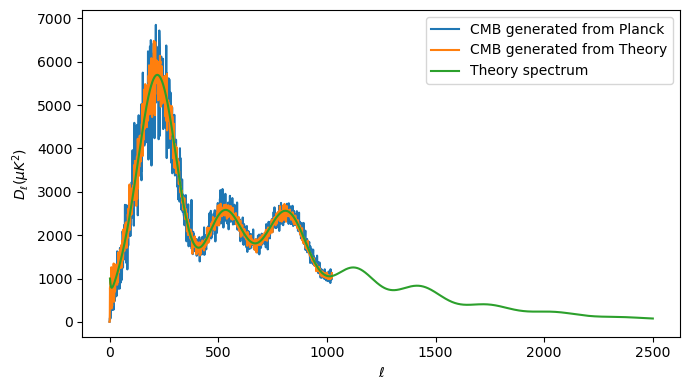

In [8]:
plt.figure(figsize=(7,4))

T_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/cmb_r0000.fits')
ell_theory, Dl_theory = power_spec_from_HP(T_map)
T_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/tutorials/data planck/CMB_realisations/cmb_r0000.fits')
ell, Dl = power_spec_from_HP(T_map)
plt.plot(ell, Dl*1e12, label='CMB generated from Planck')
plt.plot(ell_theory, Dl_theory*1e12, label='CMB generated from Theory')
ell, dl = np.loadtxt('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/cmb_spectrum_theory.txt', comments="#", usecols=(0,1), unpack=True)
dl *= (2.7255**2)
plt.plot(ell, dl*1e12, label='Theory spectrum')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell (\mu K^2)$ ")
# plt.title(r"Processed CMB $C_\ell$ vs ILC-synth ratio")
#plt.xlim(2, np.nanmax(ell_ILC) if ell_ILC.size else 2)
#plt.ylim(0.5, 1.5) # if np.max(ratio) < 2 else None
plt.legend()
plt.tight_layout()
plt.show()

# Downloaded Dust, tSZ, Sync Spectrum 

(has Pixel window, no Beam)

"sync": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"


"dust": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_thermaldust-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits",


"noise": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=ffp10_noise_{frequency}_full_map_mc_{realisation:05d}.fits",


'tsz': "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_thermalsz-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"


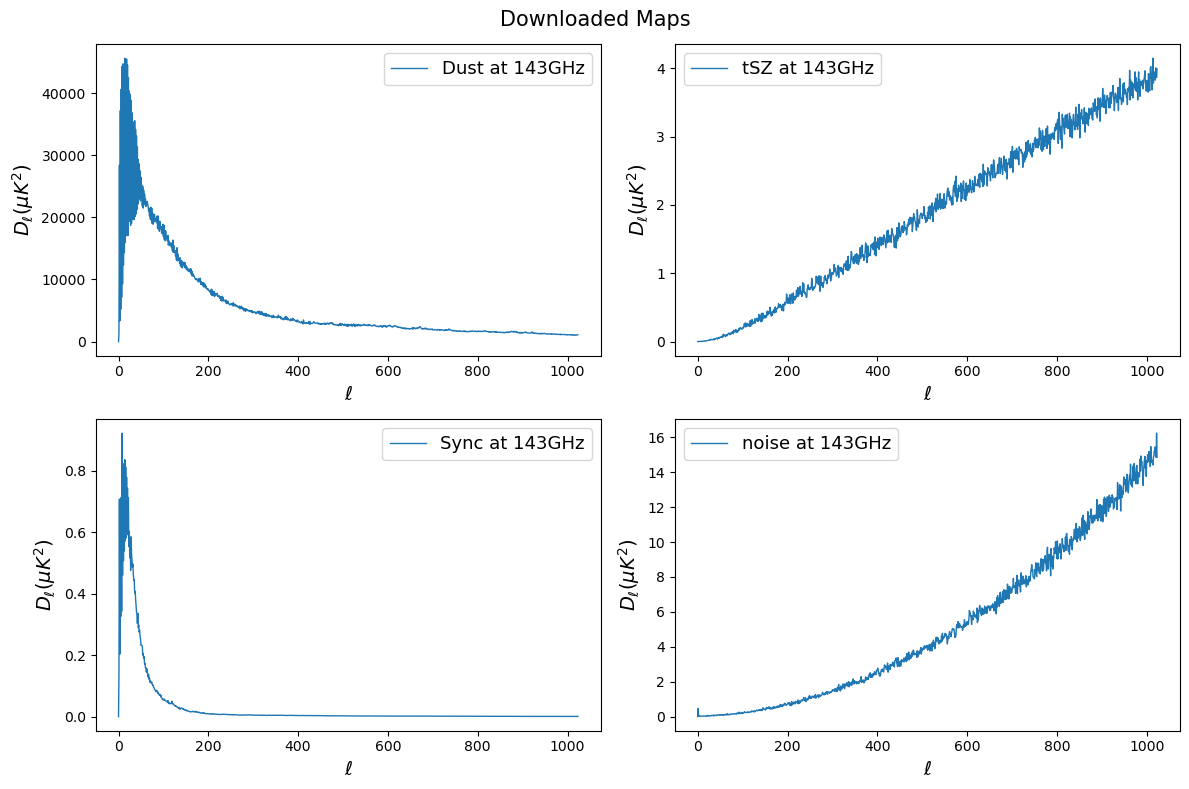

In [11]:
fig, ax = plt.subplots(2, 2, figsize = (12, 8))

freq = '143'
D_map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/dust_f{freq}.fits')
ell, Dl = power_spec_from_HP(D_map)
ax[0, 0].plot(ell, Dl*1e12, label=f'Dust at {freq}GHz', lw=1)

map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/sync_f{freq}.fits')
ell, Dl = power_spec_from_HP(map)
ax[1, 0].plot(ell, Dl*1e12, label=f'Sync at {freq}GHz', lw=1)

map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/tsz_f{freq}.fits')
ell, Dl = power_spec_from_HP(map)
ax[0, 1].plot(ell, Dl*1e12, label=f'tSZ at {freq}GHz', lw=1)

map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/noise_f{freq}_r00000.fits')
ell, Dl = power_spec_from_HP(map)
ax[1, 1].plot(ell, Dl*1e12, label=f'noise at {freq}GHz', lw=1)

for i in (0, 1):
    for j in (0, 1): 
        ax[i, j].set_xlabel(r"$\ell$", fontsize=14)
        ax[i, j].set_ylabel(r"$D_\ell (\mu K^2)$", fontsize=14)
        ax[i, j].legend(fontsize=13)

plt.suptitle('Downloaded Maps', fontsize=15)
plt.tight_layout()
plt.show()

# check n_side of downloaded noise maps 

In [38]:
freq = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
for fre in freq:
    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/noise_f{fre}_r00000.fits')
    print(fre, ' noise has n_side = ', hp.get_nside(map))
    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/tsz_f{fre}.fits')
    # print(fre, ' tsz has n_side = ', hp.get_nside(map))
    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/dust_f{fre}.fits')
    # print(fre, ' dust has n_side = ', hp.get_nside(map))
    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/sync_f{fre}.fits')
    # print(fre, ' sync has n_side = ', hp.get_nside(map))

030  noise has n_side =  1024
044  noise has n_side =  1024
070  noise has n_side =  1024
100  noise has n_side =  2048
143  noise has n_side =  2048
217  noise has n_side =  2048
353  noise has n_side =  2048
545  noise has n_side =  2048
857  noise has n_side =  2048


n_side are consistet in processed map, because noise resolution is reduced to a common scale set by l_max in MWTools.reduce_hp_map_resolution()

In [43]:
for fre in freq:
    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_noise_f{fre}_r00039_lmax512.npy')
    print(fre, ' prosecced noise has n_side = ', hp.get_nside(map))

030  prosecced noise has n_side =  256
044  prosecced noise has n_side =  256
070  prosecced noise has n_side =  256
100  prosecced noise has n_side =  256
143  prosecced noise has n_side =  256
217  prosecced noise has n_side =  256
353  prosecced noise has n_side =  256
545  prosecced noise has n_side =  256
857  prosecced noise has n_side =  256


# Processed map

* Apart from CMB: unit conversion
* Noise only: deconvolve with frequency-dependent beam
* All components: convolve with effective beam + pixel deconvolve + reduce resolution

## Processed component

Consider beam function and pixel window function during processing: 
* Noise: to mimic the real data, must deconvolve with beam function that is frequency-dependent, then convolve with an effective beam with gaussian FWHM = 5 arcmin. 
* Other foregrounds: convolve with effective beam function. 

All are deconvolved with a pixel window function. 

## $B_\ell(\nu)$, ${B_\ell}^{EFF}$, and $P_\ell$

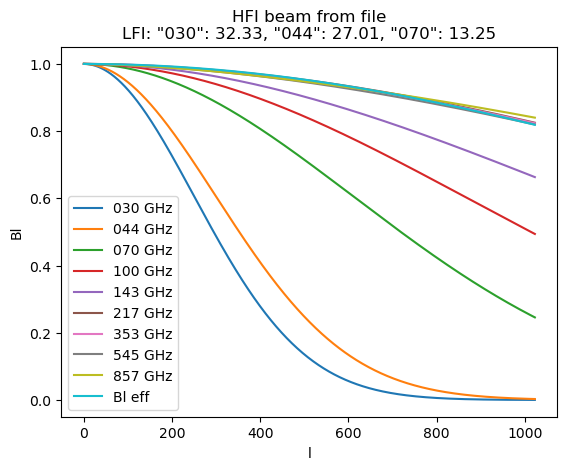

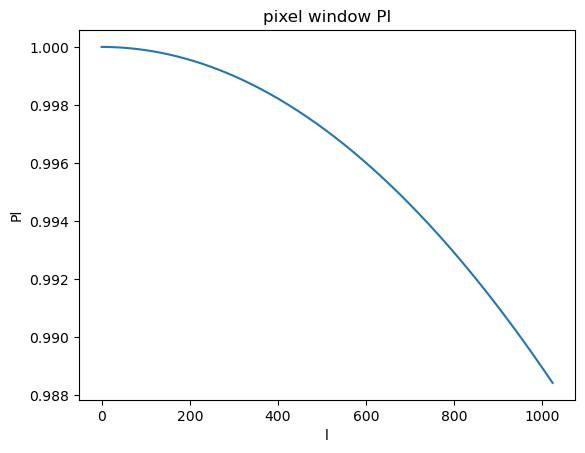

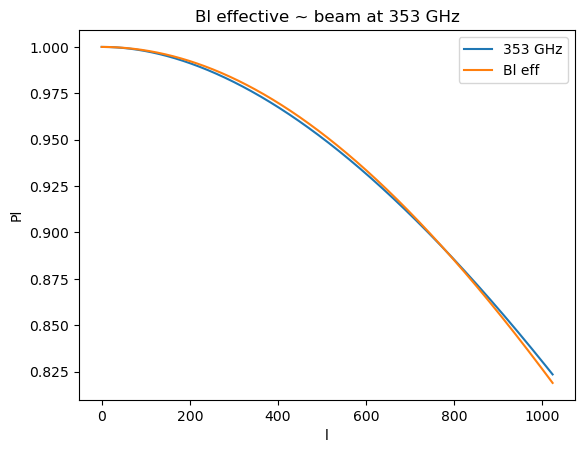

In [47]:
# HFI beam
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
lmax = 1024

for i in range(0, len(frequencies)):
    fre = frequencies[i]
    bl, bl_eff = get_bl(lmax-1, frequency=fre)
    ell = np.arange(0, 1024, 1)
    plt.plot(ell, bl[:lmax], label=f'{fre} GHz')
plt.plot(ell, bl_eff, label='Bl eff')
plt.ylabel('Bl')
plt.xlabel('l')
plt.title('HFI beam from file\nLFI: "030": 32.33, "044": 27.01, "070": 13.25')
plt.legend()
plt.show()

# pixel window 
pl = hp.sphtfunc.pixwin(2048, lmax=lmax-1, pol=False)
plt.plot(ell, pl)
plt.ylabel('Pl')
plt.xlabel('l')
plt.title(f'pixel window Pl')
plt.show()


bl, bl_eff = get_bl(lmax-1, frequency=353)
plt.plot(ell, bl[:lmax], label=f'{353} GHz')
plt.plot(ell, bl_eff, label='Bl eff')
plt.legend()
plt.title('Bl effective ~ beam at 353 GHz')
plt.ylabel('Pl')
plt.xlabel('l')
plt.show()

## Plot processed map spectrum vs downloaded for all components

Look at all frequency

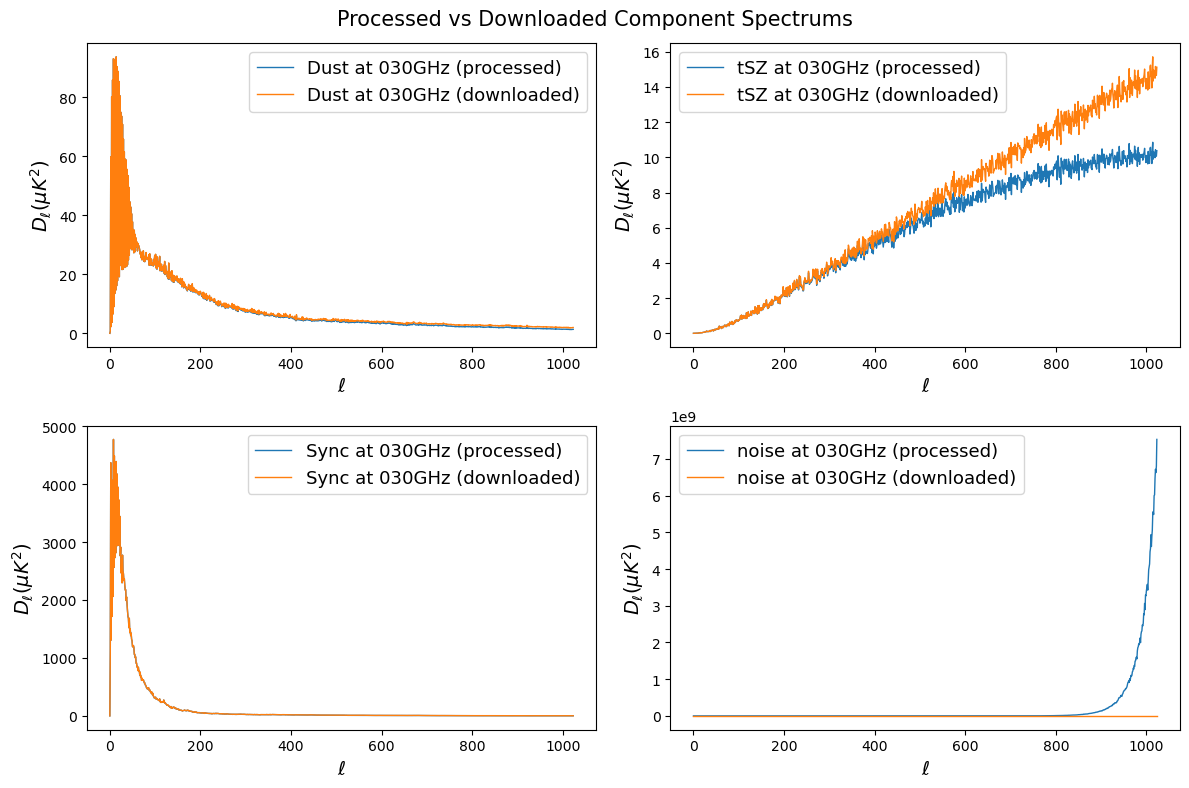

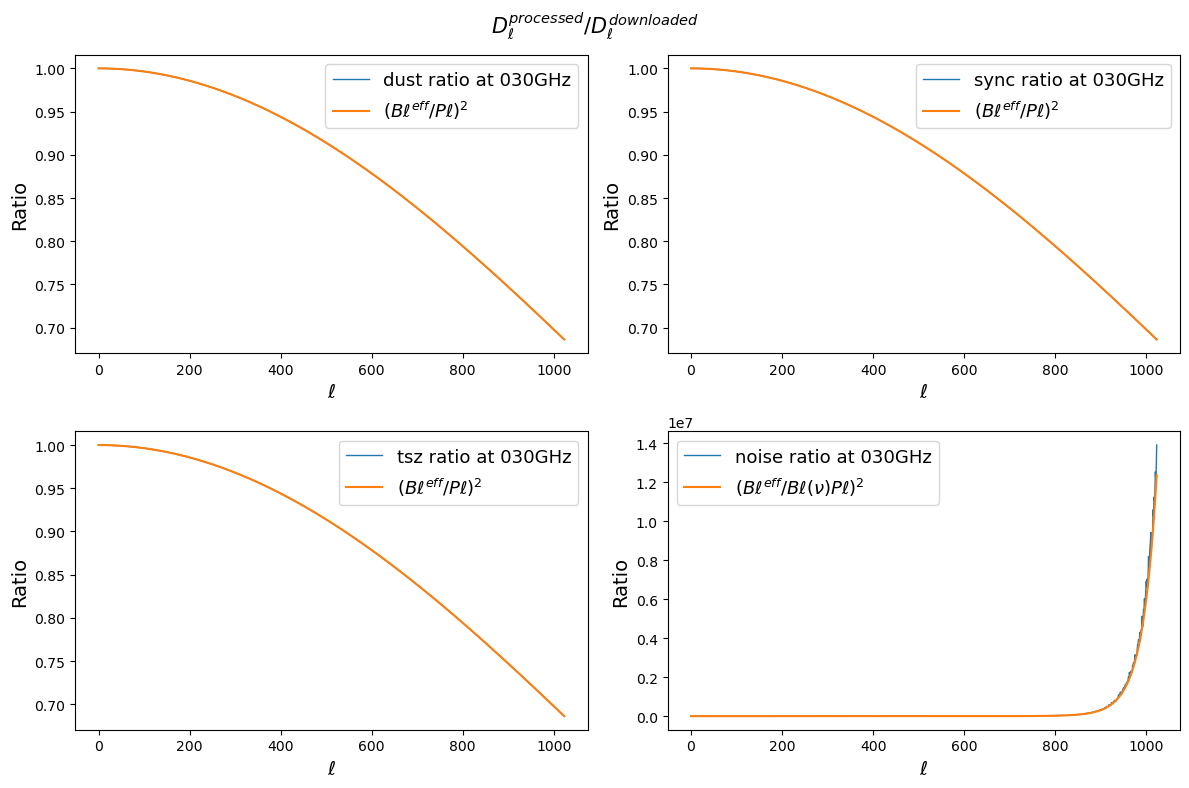

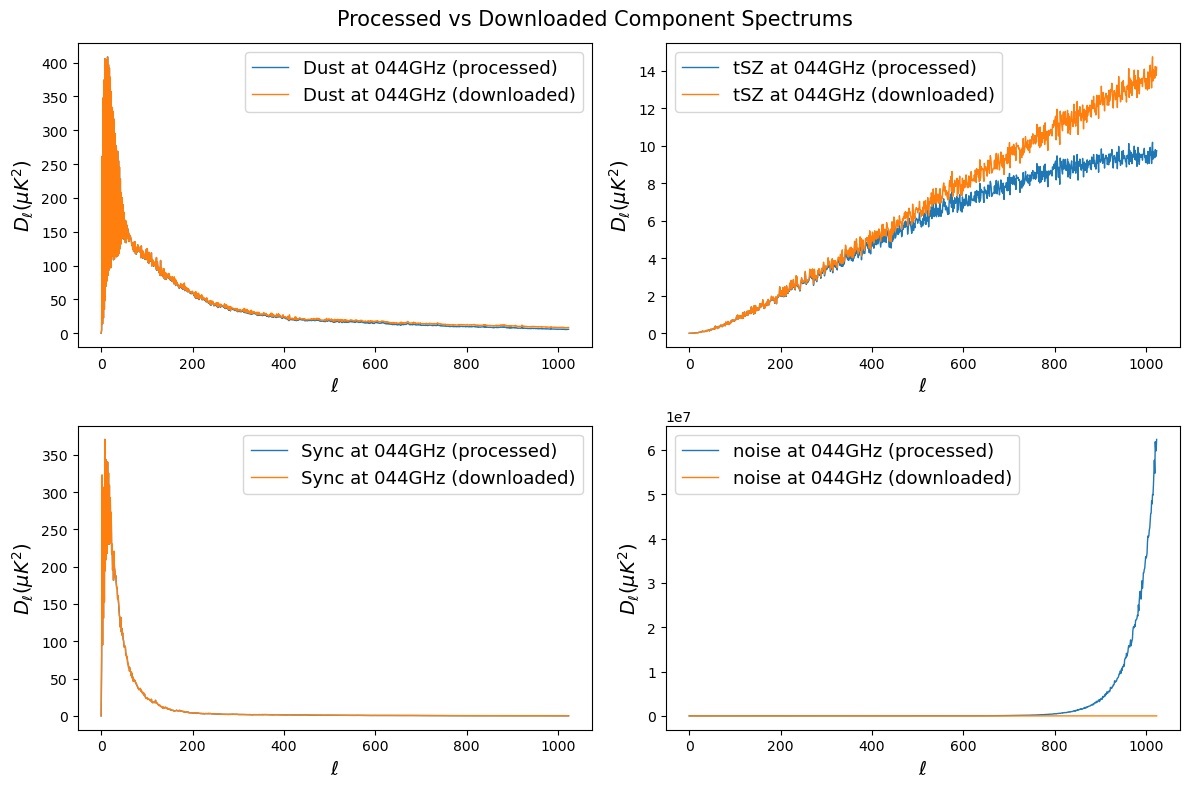

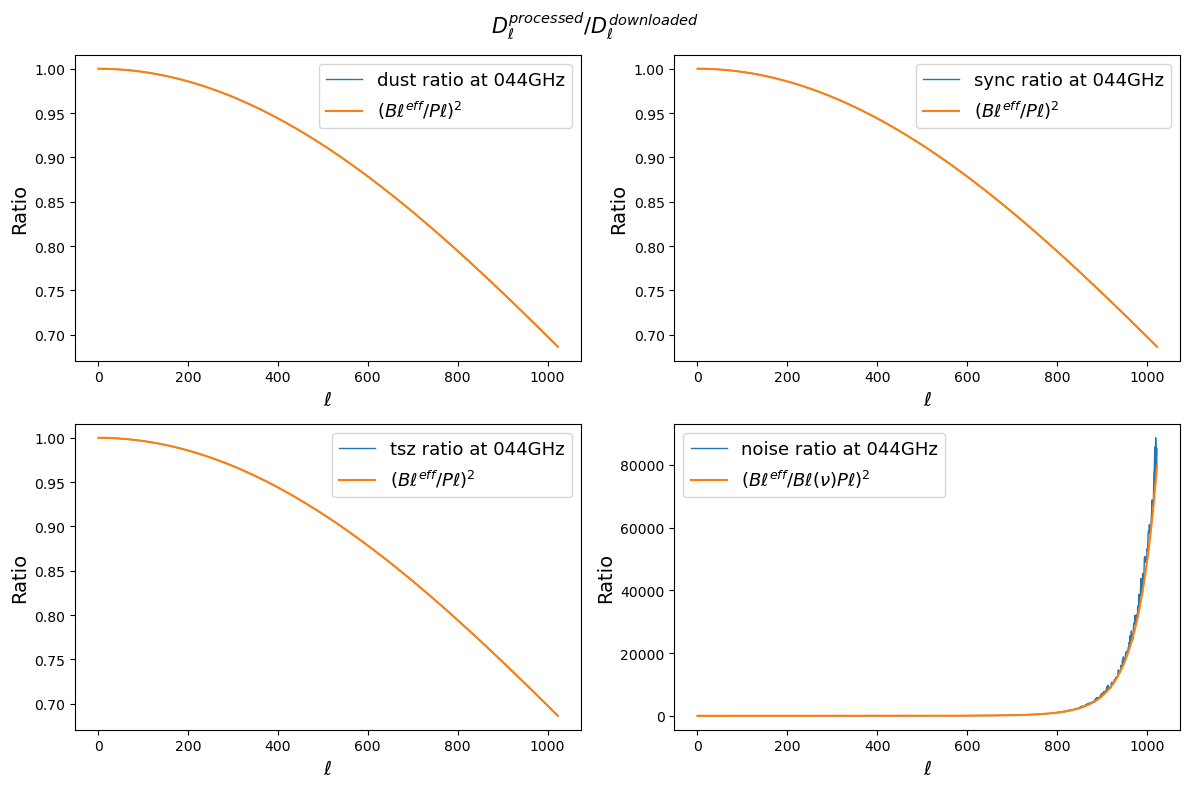

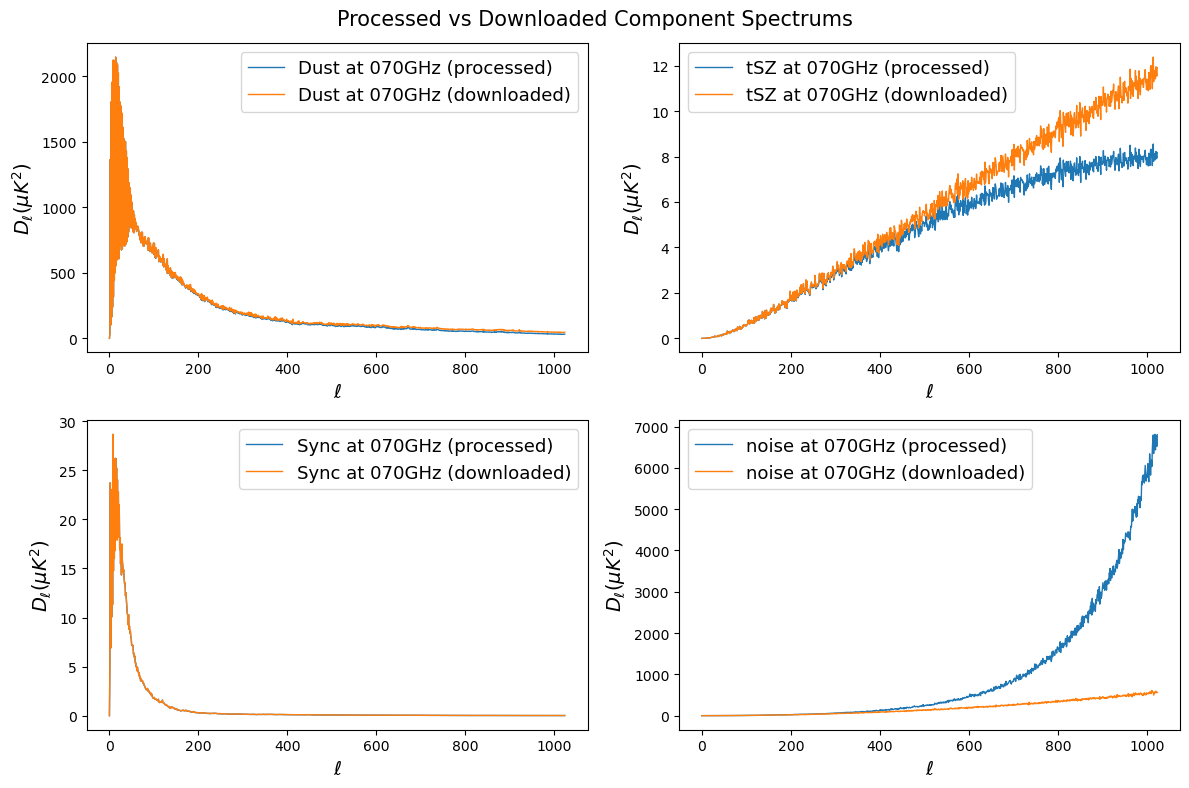

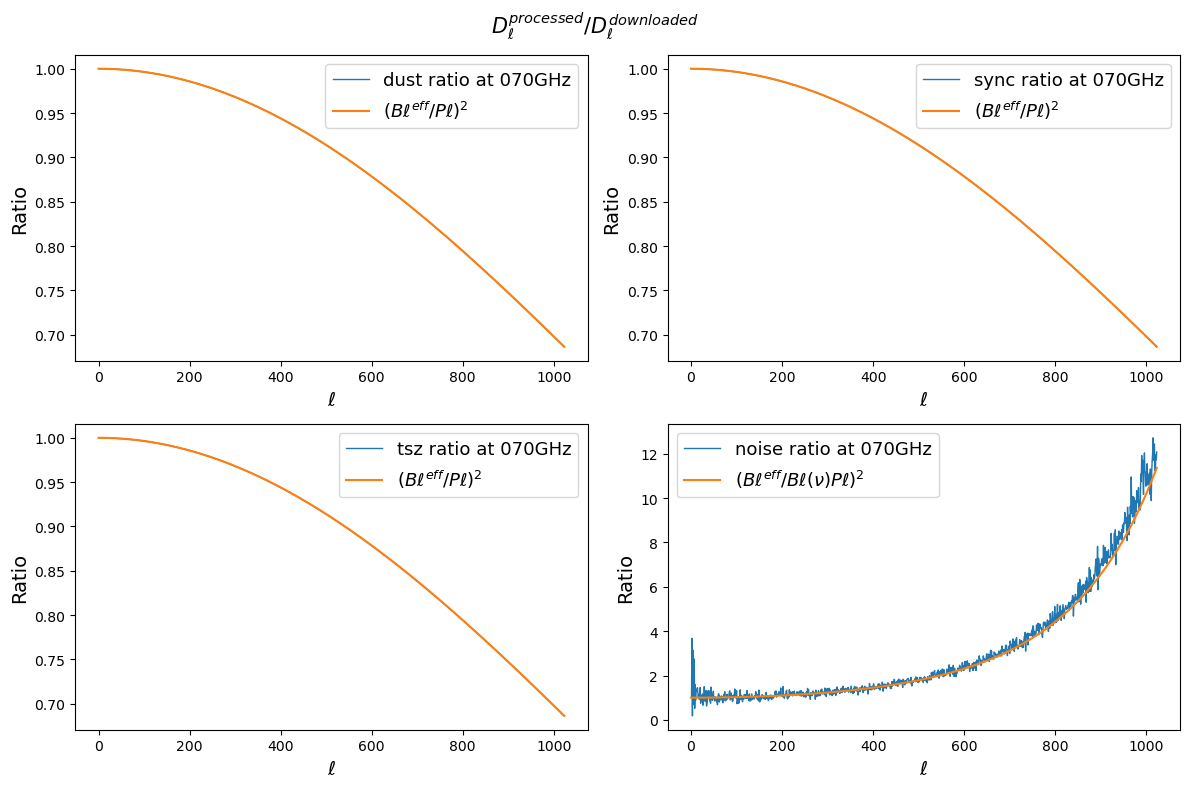

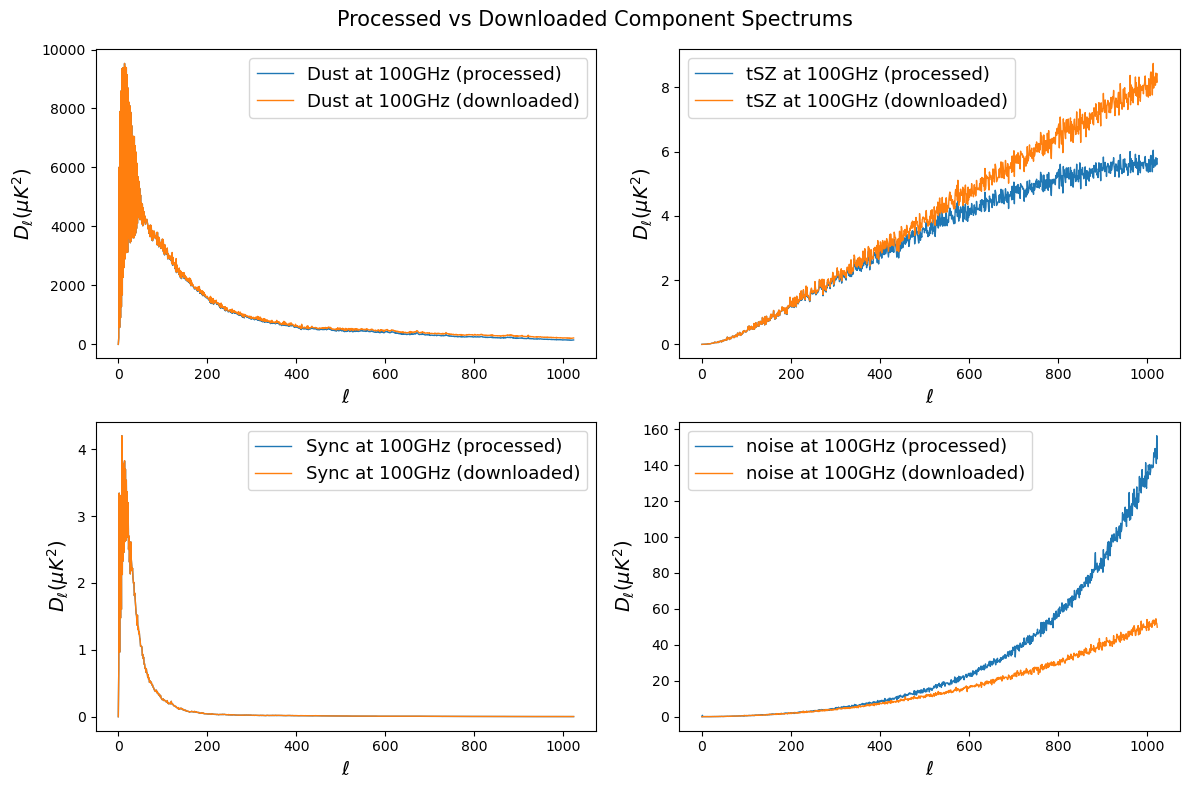

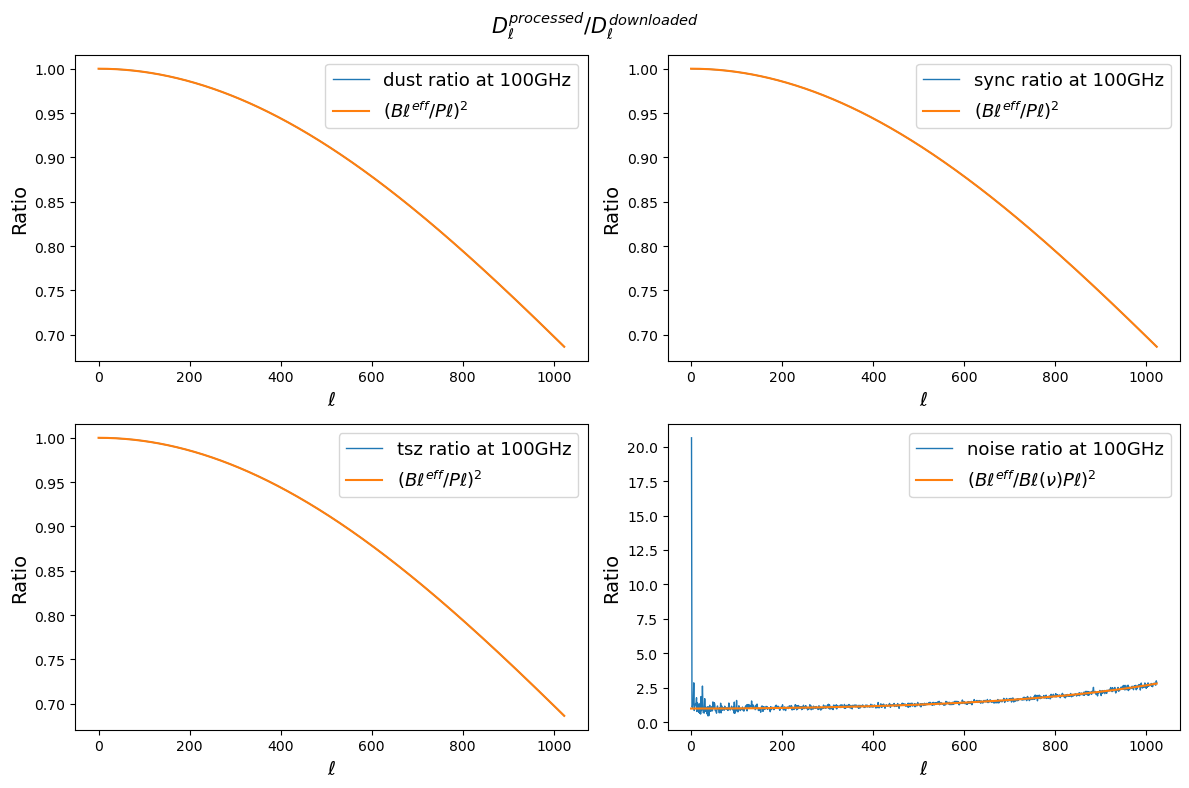

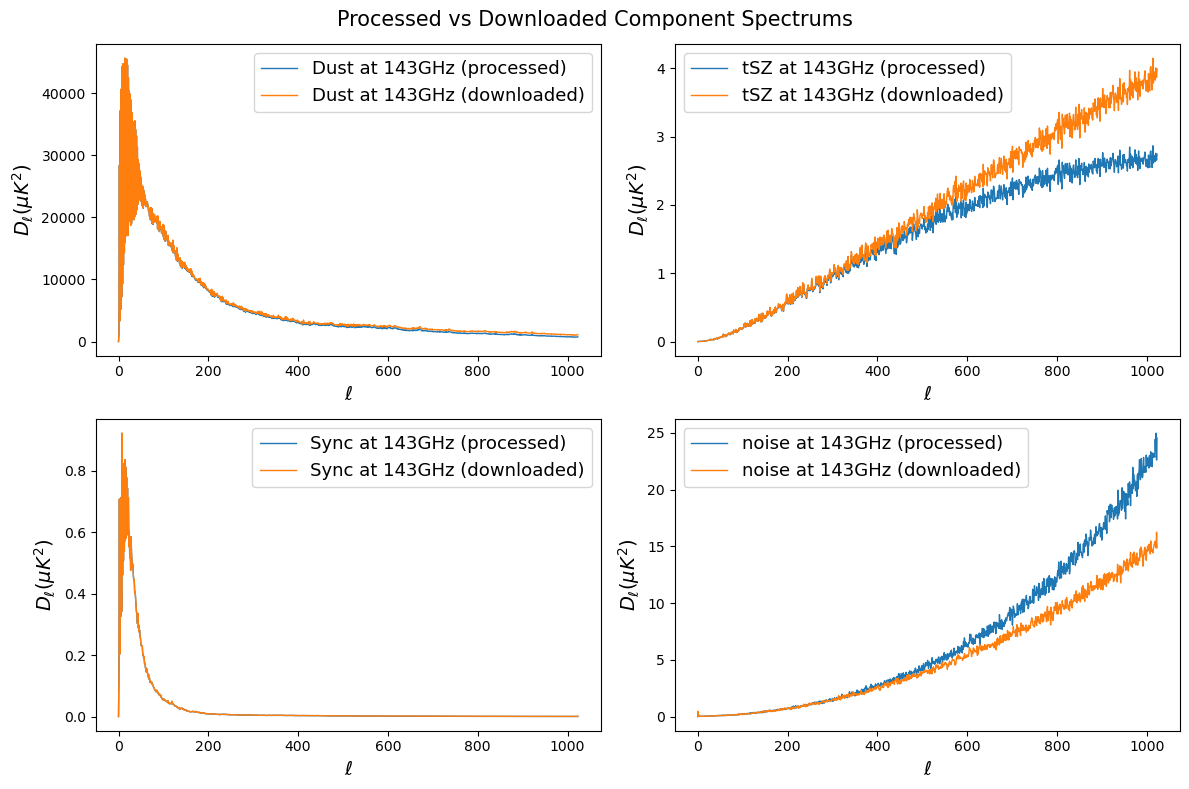

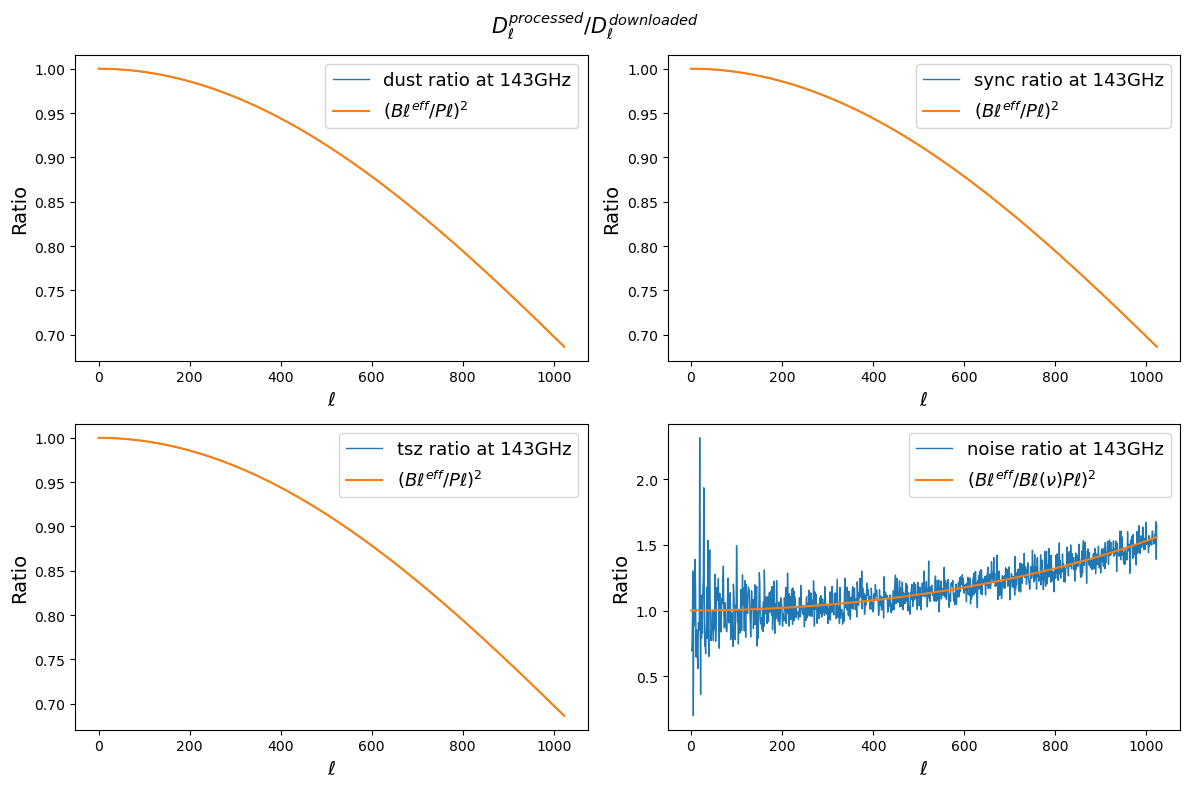

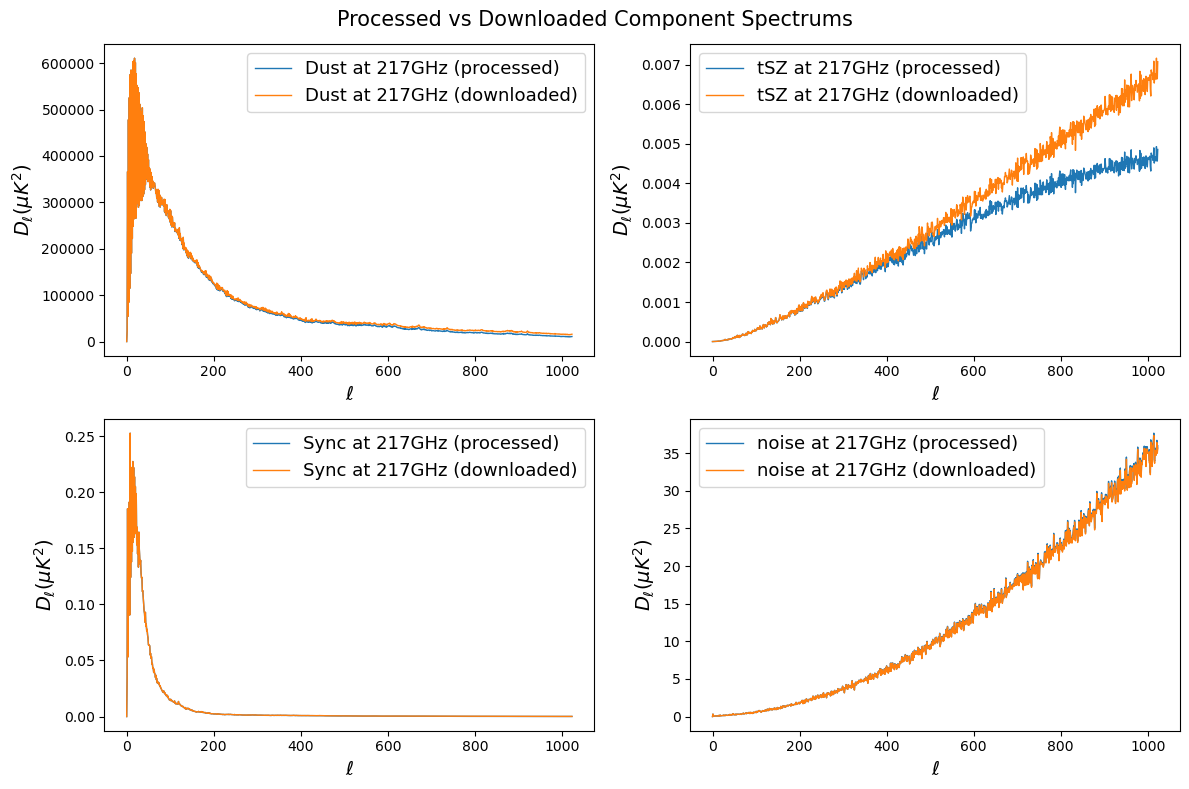

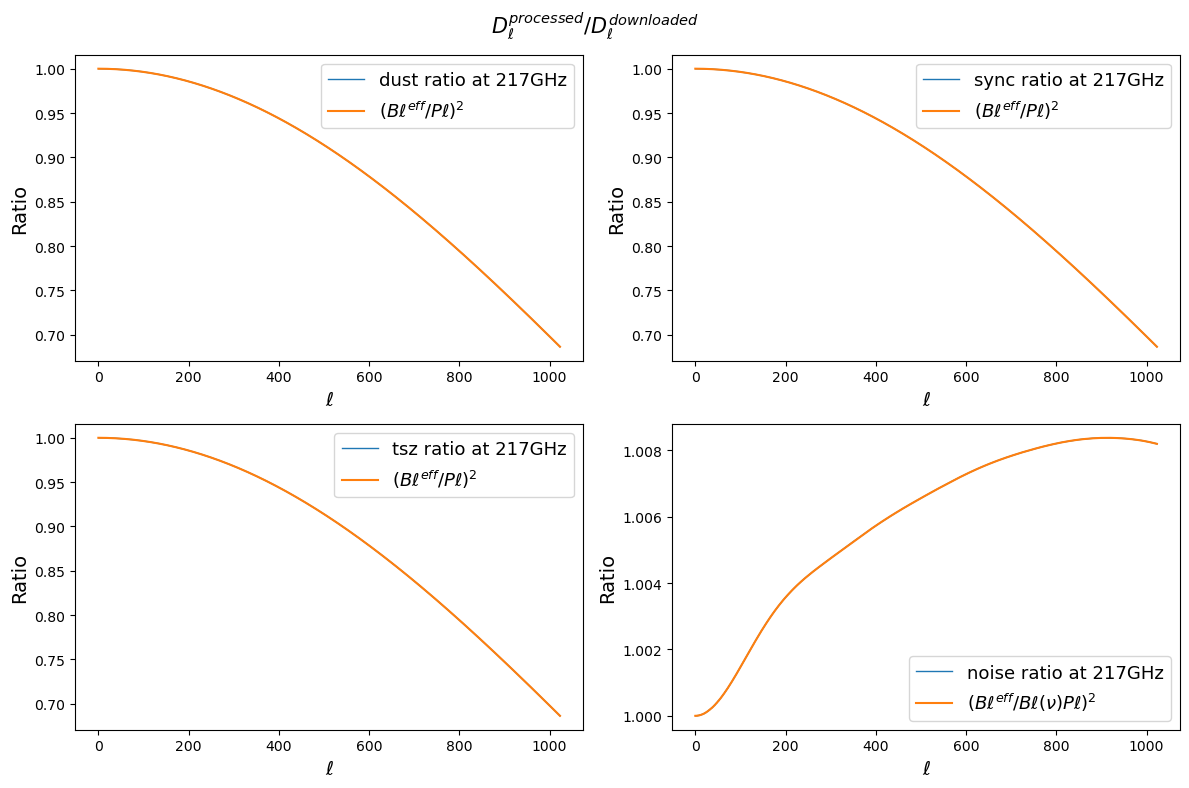

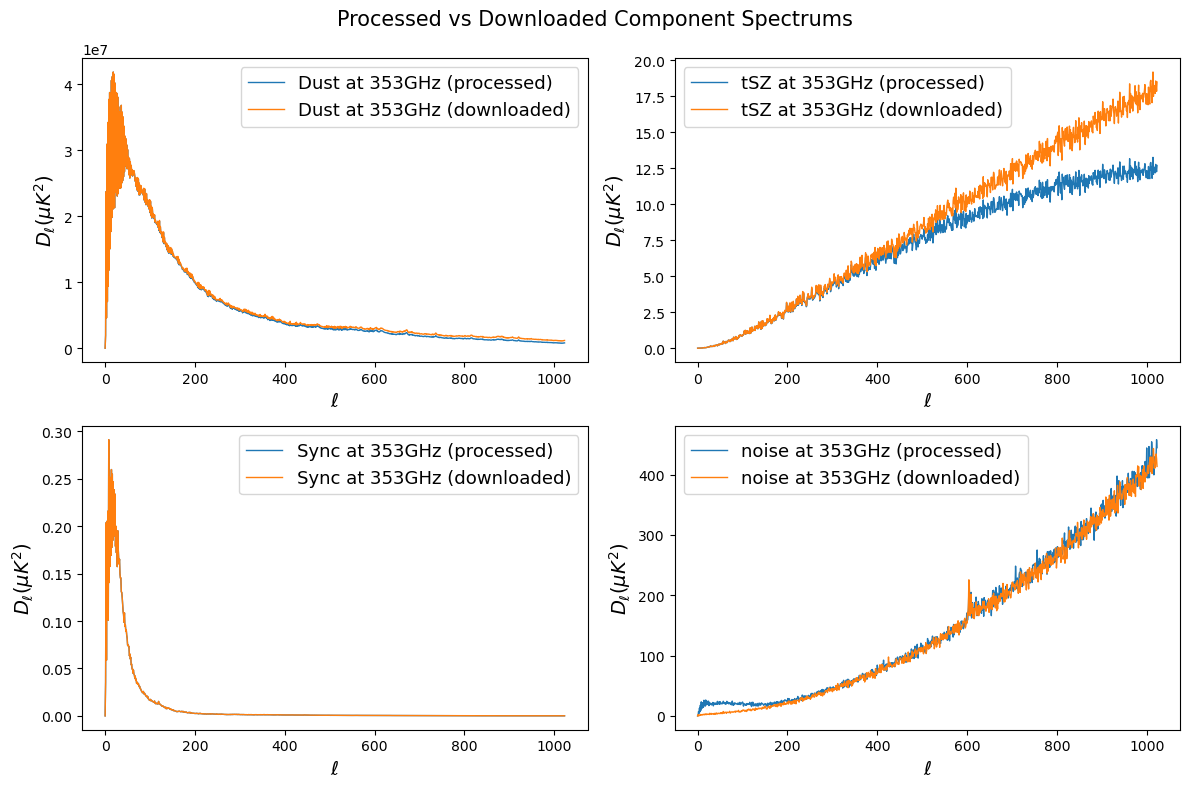

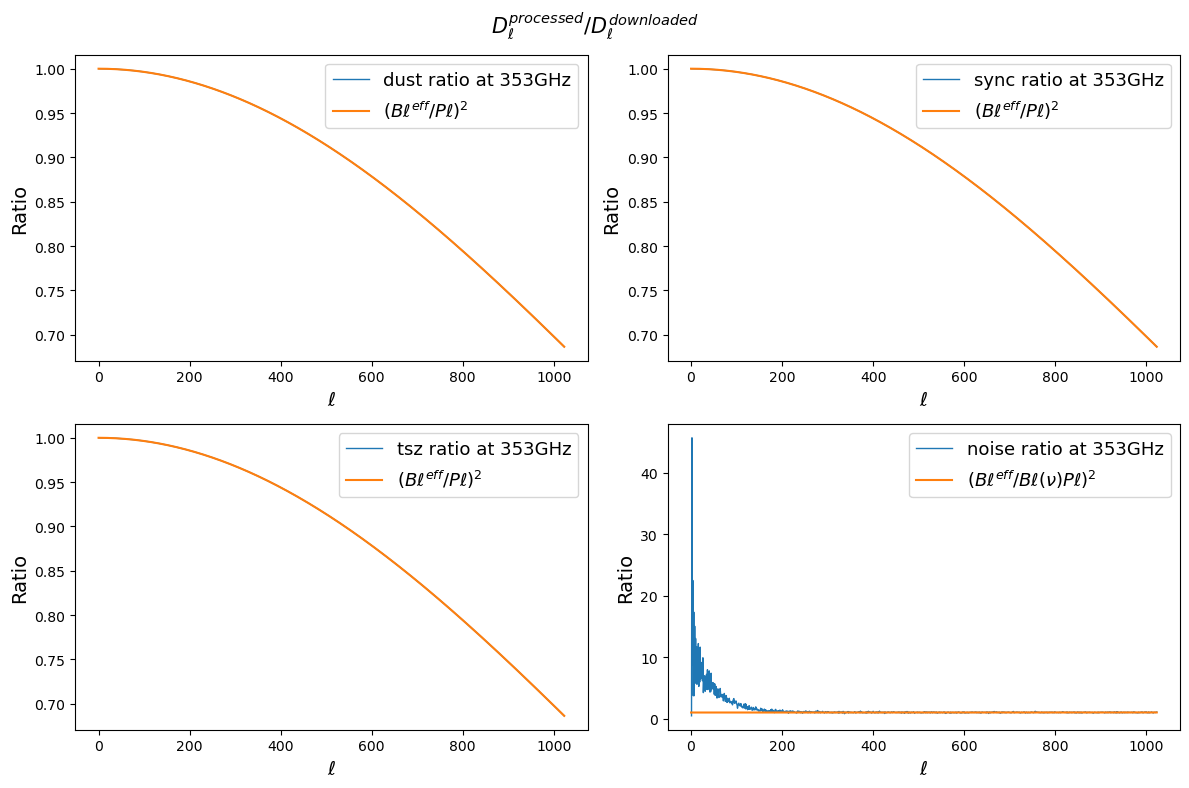

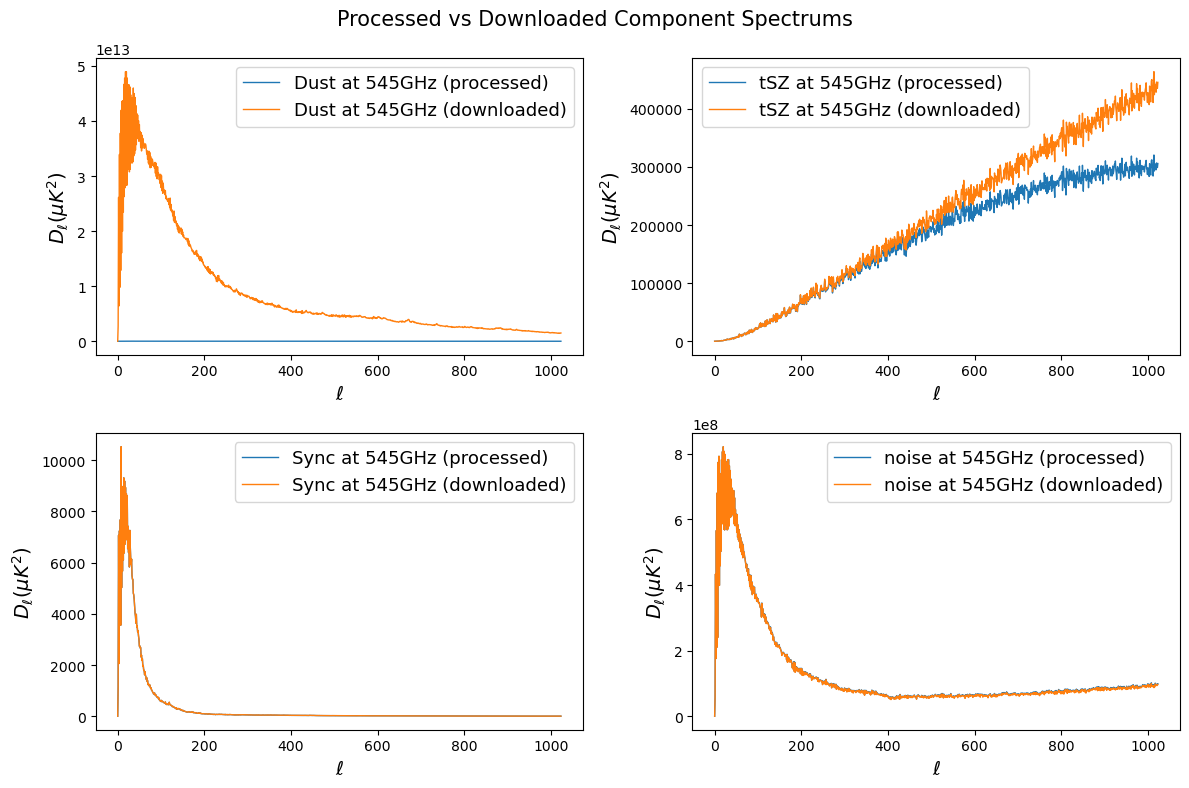

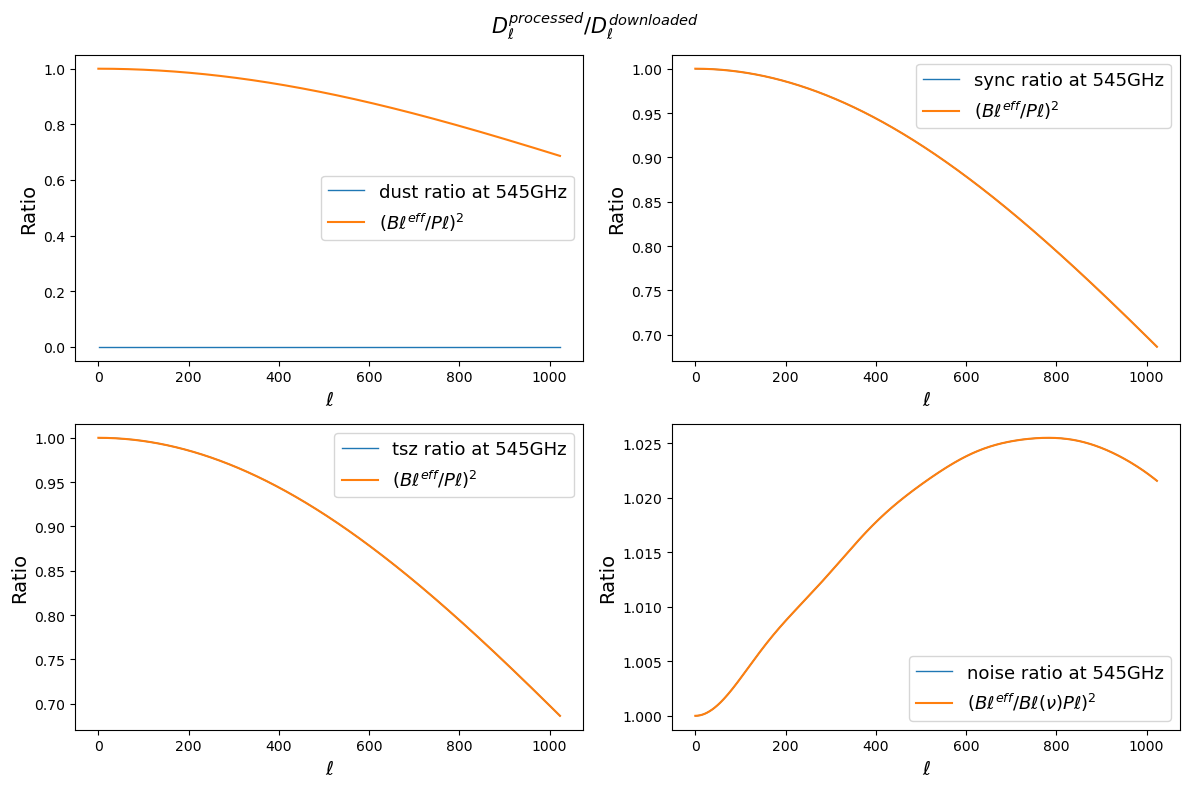

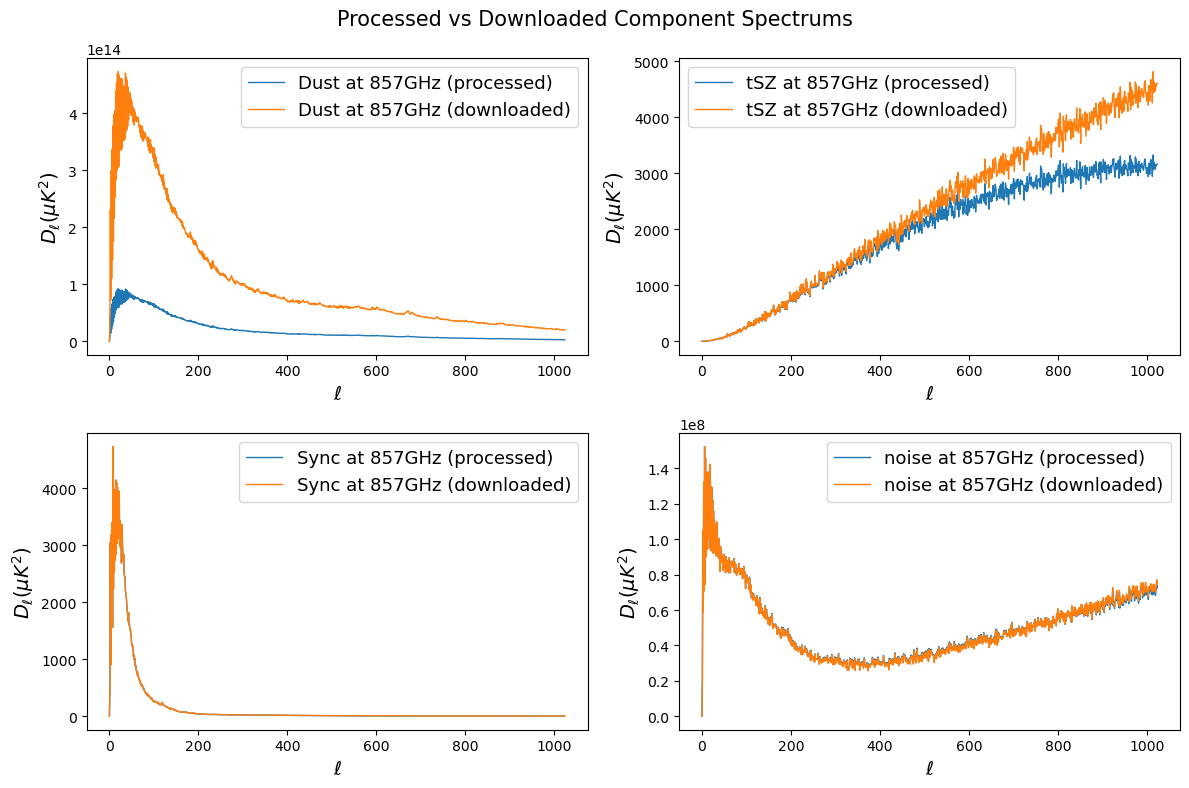

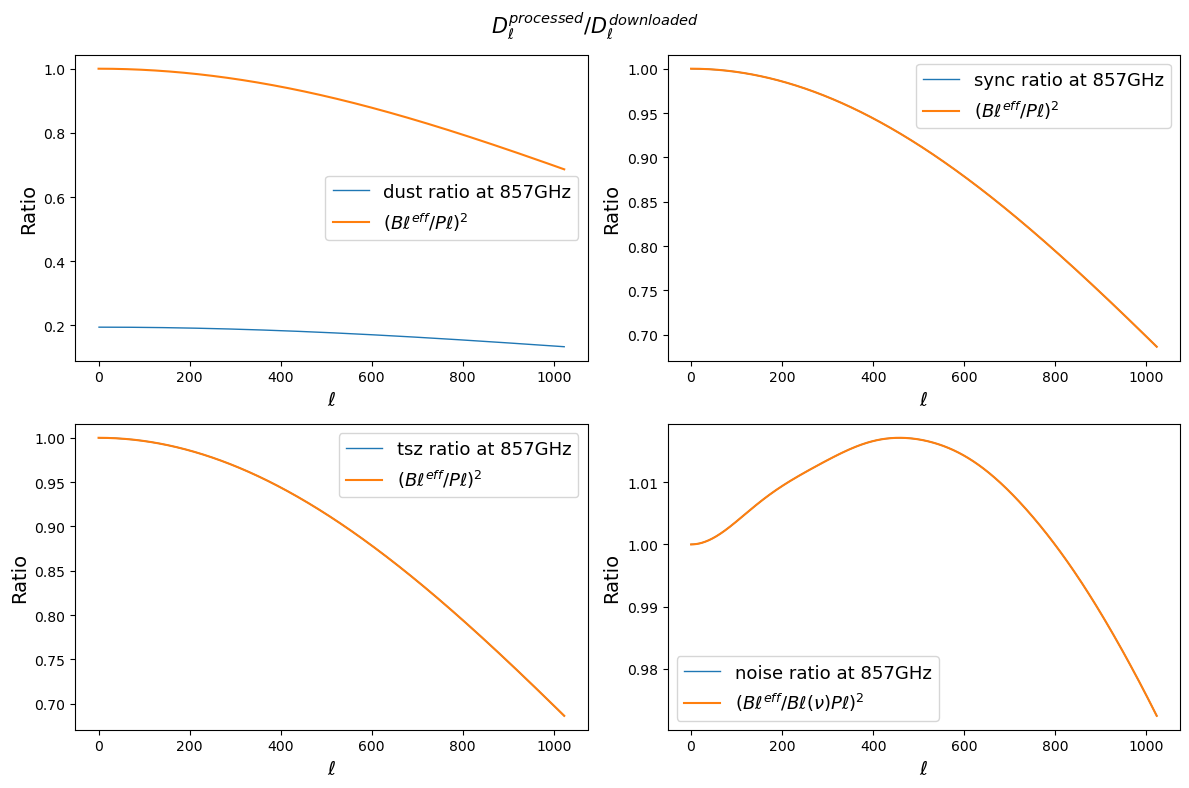

In [6]:
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]

for freq in frequencies: 

    # set unit conversion
    if freq == '545':
        unit_conversion = 58.0356
    elif freq == '857':
        unit_conversion = 2.2681
    else:
        unit_conversion = 1

    fig, ax = plt.subplots(2, 2, figsize = (12, 8))

    lmax = 1024


    # dust 
    D_map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/processed_maps/processed_dust_f{freq}_lmax{lmax}.npy')
    map *= unit_conversion
    ell, Dl_dust = power_spec_from_HP(D_map, lmax-1)
    ax[0, 0].plot(ell, Dl_dust*1e12, label=f'Dust at {freq}GHz (processed)', lw=1)

    D_map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/CMB_realisations/dust_f{freq}.fits')
    ell, Dl = power_spec_from_HP(D_map, lmax-1)
    ax[0, 0].plot(ell, Dl*1e12, label=f'Dust at {freq}GHz (downloaded)', lw=1)

    ratio_dust = Dl_dust / Dl

    # sync
    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/processed_maps/processed_sync_f{freq}_lmax{lmax}.npy')
    map *= unit_conversion
    ell, Dl_sync = power_spec_from_HP(map, lmax-1)
    ax[1, 0].plot(ell, Dl_sync*1e12, label=f'Sync at {freq}GHz (processed)', lw=1)

    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/CMB_realisations/sync_f{freq}.fits')
    ell, Dl = power_spec_from_HP(map, lmax-1)
    ax[1, 0].plot(ell, Dl*1e12, label=f'Sync at {freq}GHz (downloaded)', lw=1)

    ratio_sync = Dl_sync / Dl

    # tsz
    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/processed_maps/processed_tsz_f{freq}_lmax{lmax}.npy')
    map *= unit_conversion
    ell, Dl_tsz = power_spec_from_HP(map, lmax-1)
    ax[0, 1].plot(ell, Dl_tsz*1e12, label=f'tSZ at {freq}GHz (processed)', lw=1)

    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/CMB_realisations/tsz_f{freq}.fits')
    ell, Dl = power_spec_from_HP(map, lmax-1)
    ax[0, 1].plot(ell, Dl*1e12, label=f'tSZ at {freq}GHz (downloaded)', lw=1)

    ratio_tsz = Dl_tsz / Dl

    # noise 
    map = hp.read_map(f'Skyclean/skyclean/data/processed_maps/processed_noise_f{freq}_r00000_lmax{lmax}.npy')
    map *= unit_conversion
    ell, Dl_noise = power_spec_from_HP(map, lmax-1)
    ax[1, 1].plot(ell, Dl_noise*1e12, label=f'noise at {freq}GHz (processed)', lw=1)

    map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/CMB_realisations/noise_f{freq}_r00000.fits')
    ell, Dl = power_spec_from_HP(map, lmax-1)
    ax[1, 1].plot(ell, Dl*1e12, label=f'noise at {freq}GHz (downloaded)', lw=1)

    # get beam and pixwin
    bl, standard_bl = get_bl(lmax=lmax-1, frequency=freq)
    pl = hp.sphtfunc.pixwin(2048, lmax=lmax-1, pol=False)

    ratio_noise = Dl_noise / Dl


    # axis
    for i in (0, 1):
        for j in (0, 1): 
            ax[i, j].set_xlabel(r"$\ell$", fontsize=14)
            ax[i, j].set_ylabel(r"$D_\ell (\mu K^2)$", fontsize=14)
            ax[i, j].legend(fontsize=13)

    plt.suptitle('Processed vs Downloaded Component Spectrums', fontsize=15)
    plt.tight_layout()
    plt.show()

    # plot the ratio plot 
    fig, ax = plt.subplots(2, 2, figsize = (12, 8))
    ax[0, 0].plot(ell, ratio_dust, label=f'dust ratio at {freq}GHz', lw=1)
    ax[0, 0].plot(ell, (standard_bl/pl)**2, label=r'$(B\ell^{eff}/P\ell)^2$')

    ax[0, 1].plot(ell, ratio_sync, label=f'sync ratio at {freq}GHz', lw=1)
    ax[0, 1].plot(ell, (standard_bl/pl)**2, label=r'$(B\ell^{eff}/P\ell)^2$')

    ax[1, 0].plot(ell, ratio_tsz, label=f'tsz ratio at {freq}GHz', lw=1)
    ax[1, 0].plot(ell, (standard_bl/pl)**2, label=r'$(B\ell^{eff}/P\ell)^2$')

    ax[1, 1].plot(ell, ratio_noise, label=f'noise ratio at {freq}GHz', lw=1)
    ax[1, 1].plot(ell, (standard_bl/bl[:lmax]/pl)**2, label=r'$(B\ell^{eff}/{B\ell(\nu)P\ell})^2$')
    for i in (0, 1):
        for j in (0, 1): 
            ax[i, j].set_xlabel(r"$\ell$", fontsize=14)
            ax[i, j].set_ylabel('Ratio', fontsize=14)
            ax[i, j].legend(fontsize=13)
    plt.suptitle(r"$D_\ell^{processed} / D_\ell^{downloaded}$", fontsize=15)
    plt.tight_layout()
    plt.show()


Above figures are using data from cILC pipeline.

## Processed CMB map (pixel, beam deconvolve)


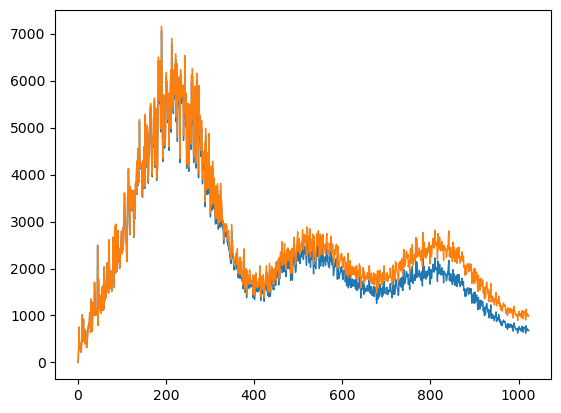

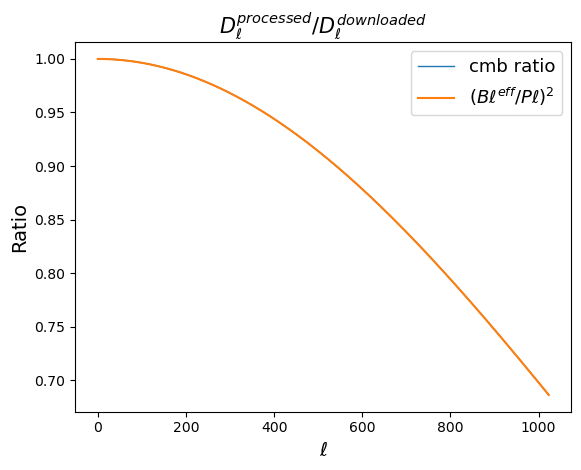

In [10]:
lmax = 1024
c_map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/processed_maps/processed_cmb_r0000_lmax{lmax}.npy')
ell, Dl_cmb = power_spec_from_HP(c_map, lmax-1)
plt.plot(ell, Dl_cmb*1e12, label=f'CMB (processed)', lw=1)

map = hp.read_map(f'/Scratch/cindy/Skyclean/Skyclean/skyclean/data/CMB_realisations/cmb_r0000.fits')
ell, Dl = power_spec_from_HP(map, lmax-1)
plt.plot(ell, Dl*1e12, label=f'CMB (downloaded)', lw=1)
plt.show()

ratio_cmb = Dl_cmb / Dl

plt.plot(ell, ratio_cmb, label=f'cmb ratio', lw=1)

# get beam and pixwin
bl, standard_bl = get_bl(lmax=lmax-1, frequency=freq)
pl = hp.sphtfunc.pixwin(hp.get_nside(map), lmax=lmax-1, pol=False)

plt.plot(ell, (standard_bl/pl)**2, label=r'$(B\ell^{eff}/P\ell)^2$')

plt.xlabel(r"$\ell$", fontsize=14)
plt.ylabel(r"Ratio", fontsize=14)
plt.legend(fontsize=13)

plt.title(r"$D_\ell^{processed} / D_\ell^{downloaded}$", fontsize=15)
plt.show()


Beam and pixwindow in CMB is correct, checked

## sum of individual spectrum 

$\sum Cl_i$ where i = dust, noise, CMB, sync

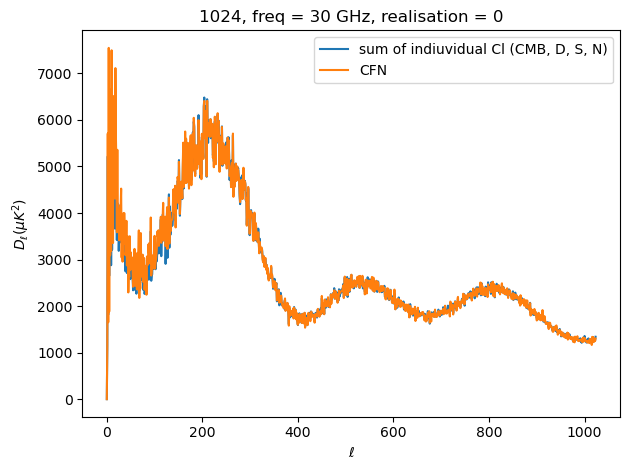

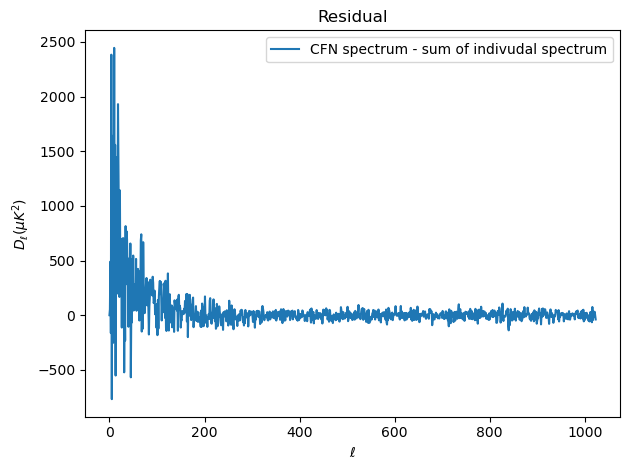

In [71]:
# at realisation 0, freq = 30GHz

# sum 
Dl_sum = 0
map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_cmb_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)
Dl_sum += Dl
D_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_dust_f030_lmax1023.npy')
ell, Dl = power_spec_from_HP(D_map)
Dl_sum += Dl
N_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_noise_f030_r00000_lmax1023.npy')
ell, Dl = power_spec_from_HP(N_map)
Dl_sum += Dl
S_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_sync_f030_lmax1023.npy')
ell, Dl = power_spec_from_HP(S_map)
Dl_sum += Dl
plt.plot(ell, Dl_sum*1e12, label='sum of indiuvidual Cl (CMB, D, S, N)')

# CFN
map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CFN_realisations/cfn_f030_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)
plt.plot(ell, Dl*1e12, label='CFN')

plt.title('1024, freq = 30 GHz, realisation = 0')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell (\mu K^2)$ ")
plt.legend()
plt.tight_layout()
plt.show()

# residual map 
plt.plot(ell, (Dl-(Dl_sum))*1e12, label='CFN spectrum - sum of indivudal spectrum')
plt.title('Residual')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell (\mu K^2)$ ")
plt.legend()
plt.tight_layout()
plt.show()

## **TO DO**: Look at Ag's derivation on varifying the ratio 

## Is there a meaning of this plot?

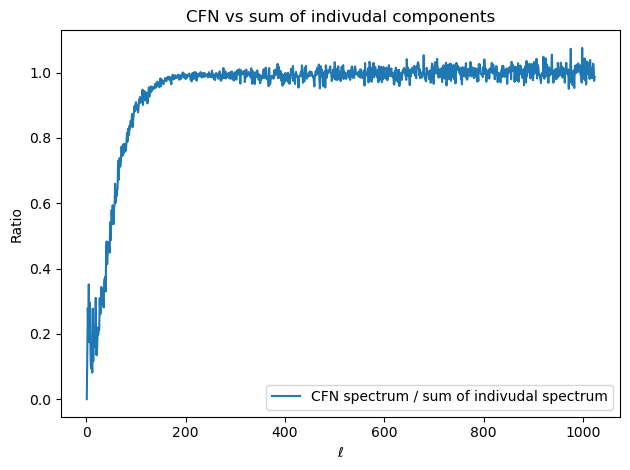

In [ ]:
# at realisation 0, freq = 30GHz

# sum 
Dl_sum = 0
map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_cmb_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)
Dl_sum += Dl
D_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_dust_f030_lmax1023.npy')
ell, Dl = power_spec_from_HP(D_map)
Dl_sum += Dl
N_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_noise_f030_r00000_lmax1023.npy')
ell, Dl = power_spec_from_HP(N_map)
Dl_sum += Dl
S_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_sync_f030_lmax1023.npy')
ell, Dl = power_spec_from_HP(S_map)
Dl_sum += Dl

# CFN
map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CFN_realisations/cfn_f030_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)

# ratio plot 
plt.plot(ell, (Dl/(Dl_sum)), label='CFN spectrum / sum of indivudal spectrum')
plt.title('1024, freq = 30 GHz, realisation = 0, lam = 4.0')
plt.xlabel(r"$\ell$")
plt.ylabel("Ratio")
plt.legend()
plt.tight_layout()
plt.show()

# ILC synthesised spectrum 

## [cmb, tsz, sync, noise]

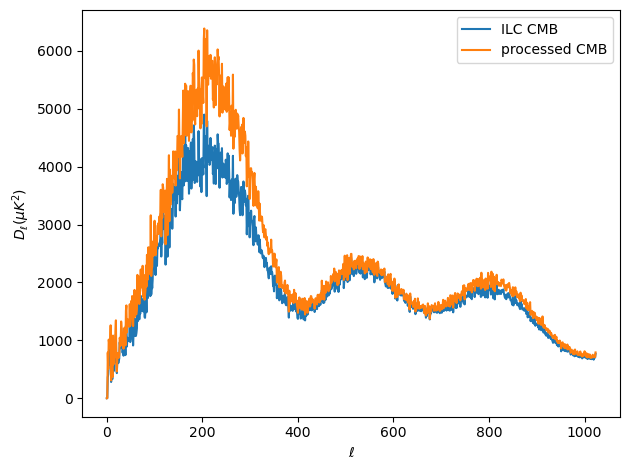

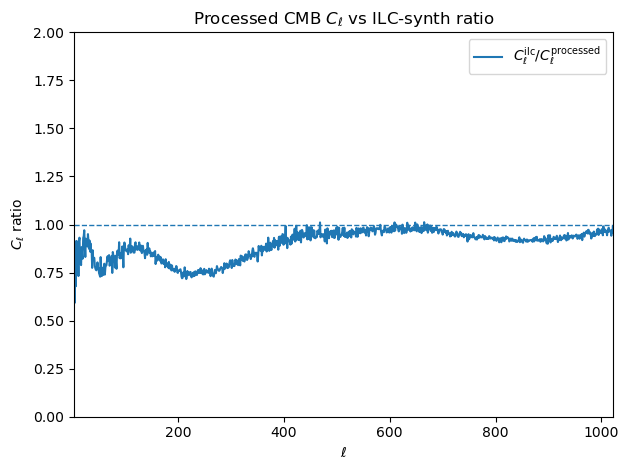

In [4]:
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1024.fits')
ell, ilc_Dl = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl*1e12, label='ILC CMB')
'''
T_map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/CMB_realisations/cmb_r0000.fits')
ell_theory, Dl_theory = power_spec_from_HP(T_map)
plt.plot(ell_theory, Dl_theory*1e12, label='theory CMB (with Pl)')
ell_theory, Dl_theory = power_spec_from_HP(T_map, Pl=True)
plt.plot(ell_theory, Dl_theory*1e12, label='theory CMB (without Pl)')
'''
map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_cmb_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)
plt.plot(ell, Dl*1e12, label='processed CMB')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell (\mu K^2)$ ")
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(ell, ilc_Dl / Dl, label=r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed}$')
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$ ratio")
plt.title(r"Processed CMB $C_\ell$ vs ILC-synth ratio")
plt.xlim(2, np.nanmax(ell) if ell.size else 2)
plt.ylim(0.0, 2.) # if np.max(ratio) < 2 else None
plt.legend()
plt.tight_layout()
plt.show()


## ['cmb', 'tsz', 'noise']

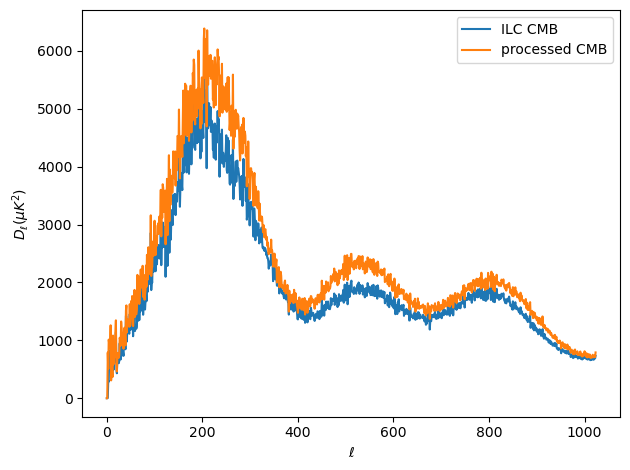

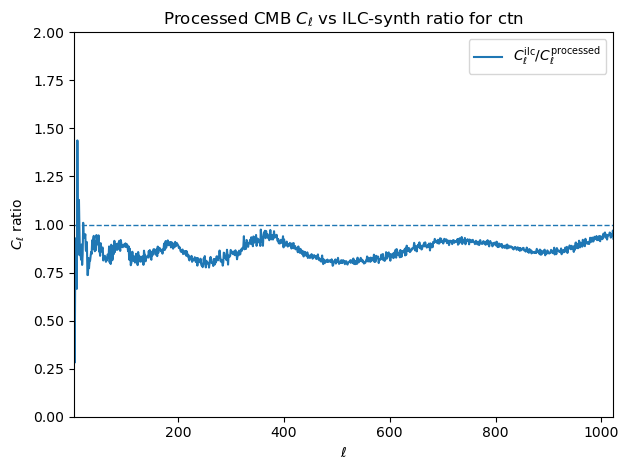

In [ ]:
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1024_lam2.0_ctn.fits')
ell, ilc_Dl = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl*1e12, label='ILC CMB')

map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_cmb_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)
plt.plot(ell, Dl*1e12, label='processed CMB')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell (\mu K^2)$ ")
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(ell, ilc_Dl / Dl, label=r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed}$')
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$ ratio")
plt.title(r"Processed CMB $C_\ell$ vs ILC-synth ratio for ctn")
plt.xlim(2, np.nanmax(ell) if ell.size else 2)
plt.ylim(0.0, 2.) # if np.max(ratio) < 2 else None
plt.legend()
plt.tight_layout()
plt.show()


## plot spectrum (with different components inputs) ratio on the same plot 

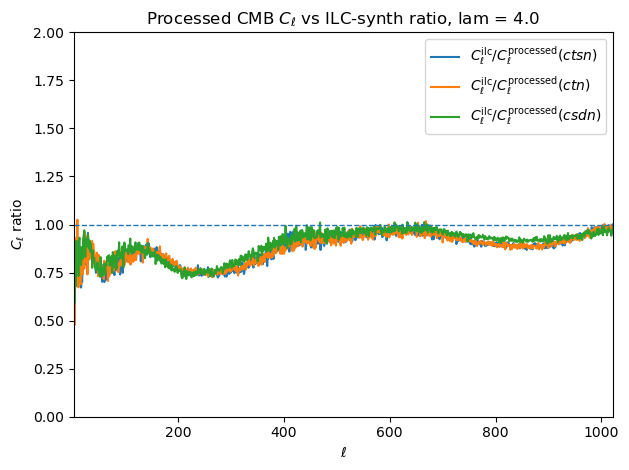

In [6]:
# processed cmb
map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_cmb_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)

# ctsn 
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1023_cstn.fits')
ell, ilc_Dl_cstn = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl_cstn / Dl, label=r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed} (ctsn)$')

# ctn
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1023_lam4.0_ctn.fits')
ell, ilc_Dl_ctn = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl_ctn / Dl, label=r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed} (ctn)$')

# csdn
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1023_csdn.fits')
ell, ilc_Dl_csdn = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl_csdn / Dl, label=r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed} (csdn)$')

plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$ ratio")
plt.title(r"Processed CMB $C_\ell$ vs ILC-synth ratio, lam = 4.0")
plt.xlim(2, np.nanmax(ell) if ell.size else 2)
plt.ylim(0.0, 2.) # if np.max(ratio) < 2 else None
plt.legend()
plt.tight_layout()
plt.show()


at same lambda, there is barely difference between using different components as inputs

## Lambda = 2.0

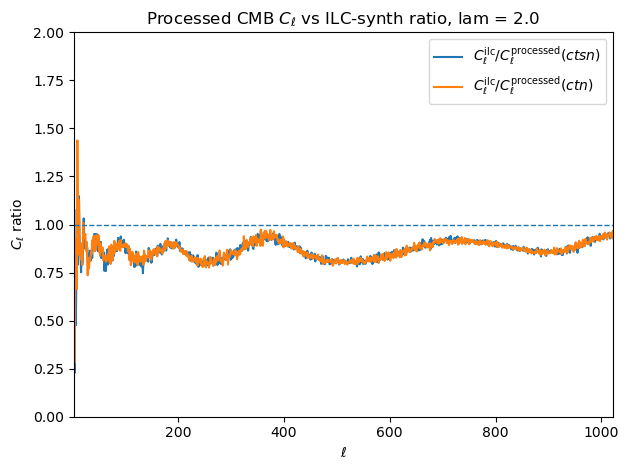

In [34]:
# processed cmb
map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_cmb_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)

# ctsn 
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1023_lam2.0_cstn.fits')
ell, ilc_Dl_cstn = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl_cstn / Dl, label=r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed} (ctsn)$')

# ctn
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1023_lam2.0_ctn.fits')
ell, ilc_Dl_ctn = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl_ctn / Dl, label=r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed} (ctn)$')

# csdn
#map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1023_lam2.0_cdsn.fits')
#ell, ilc_Dl_csdn = power_spec_from_HP(map)
#plt.plot(ell, ilc_Dl_csdn / Dl, label=r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed} (csdn)$')

plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$ ratio")
plt.title(r"Processed CMB $C_\ell$ vs ILC-synth ratio, lam = 2.0")
plt.xlim(2, np.nanmax(ell) if ell.size else 2)
plt.ylim(0.0, 2.) # if np.max(ratio) < 2 else None
plt.legend()
plt.tight_layout()
plt.show()


## Compare ILC-syn spectrum at different lambda

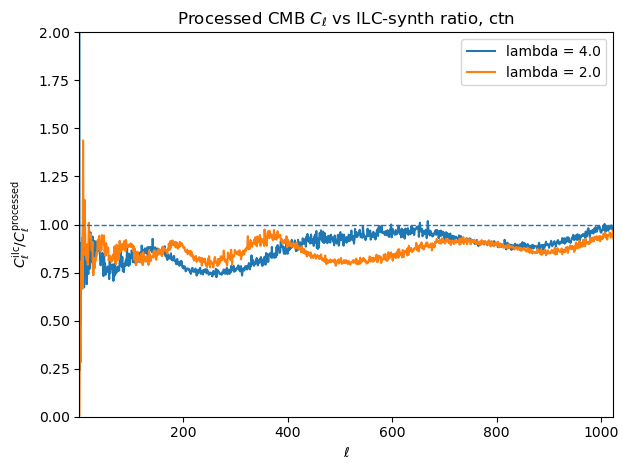

In [7]:
# processed cmb
map = hp.read_map('/Scratch/cindy/Skyclean/Skyclean_C/skyclean/data/processed_maps/processed_cmb_r0000_lmax1023.npy')
ell, Dl = power_spec_from_HP(map)

# ctn at lam = 4.0
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1023_lam4.0_ctn.fits')
ell, ilc_Dl_ctn_4 = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl_ctn_4 / Dl, label='lambda = 4.0')

# lam = 2.0
map = hp.read_map('/Scratch/cindy/Skyclean/ilc_cmb_1023_lam2.0_ctn.fits')
ell, ilc_Dl_ctn_2 = power_spec_from_HP(map)
plt.plot(ell, ilc_Dl_ctn_2 / Dl, label='lambda = 2.0')

plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel(r"$\ell$")
plt.ylabel(r'$C_\ell^{\rm ilc}/C_\ell^{\rm processed}$')
plt.title(r"Processed CMB $C_\ell$ vs ILC-synth ratio, ctn")
plt.xlim(2, np.nanmax(ell) if ell.size else 2)
plt.ylim(0.0, 2.) # if np.max(ratio) < 2 else None
plt.legend()
plt.tight_layout()
plt.show()

* We expect: lower lambda = narrower filter = less samplings = greater negative bias
* We observe: lower lambda gives smaller bias at $0<\ell<400$; lower lambda gives greater bias at $400<\ell<1024$

# Spectrum after wavelet trasform, per scale j, before ILC

Wavelet kernel function, $\psi^{(j)}_{\ell m}$, at different scales j.

wavelet kernel shape: (n_scales, L, 2L-1) = (6, 1023, 2045)


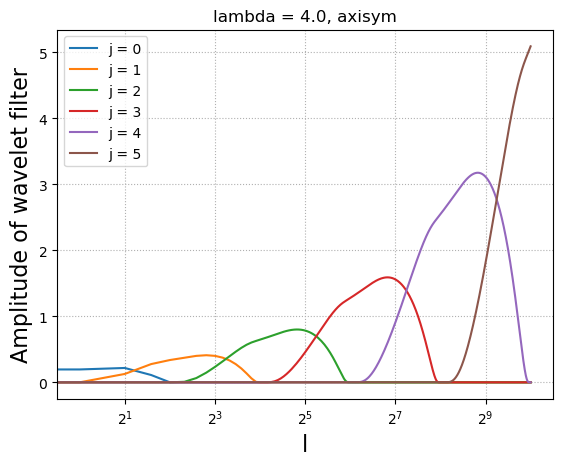

In [3]:
import s2wav.filters as filters 
import numpy as np
import matplotlib.pyplot as plt

L = 1023
lam = 4.0
wavelet_fnc, scaling_fnc = filters.filters_directional_vectorised(L=L, N=1, lam=lam)
print('wavelet kernel shape: (n_scales, L, 2L-1) =', wavelet_fnc.shape)
m0 = L-1 # the centre index 

# visualise the wavelet 
l_list = np.arange(0, L, 1)
shape = wavelet_fnc.shape
for i in range(shape[0]):
    plt.plot(l_list, np.abs(wavelet_fnc[i,:,m0]), label = f"j = {i}")
plt.xlabel("l", fontsize=16)
plt.ylabel("Amplitude of wavelet filter", fontsize=16)
plt.title(f"lambda = {lam}, axisym")
plt.xscale('log', base=2)
plt.legend()
plt.grid(ls=':')
plt.show()

boris paper